This notebook shows how the library can be used. 
First we read the videos, then we process them and finally we train a model

In [1]:
import pickle
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVC

from joblib import dump
import csv
import tracemalloc
from app.HandHygieneMain import *
import mediapipe as mp
import warnings
warnings.filterwarnings("ignore")

PATH = r'D:\\Proyectos\\Hands\\HigieneManos' # path to folder
#PATH = '/Users/juannquinones/Library/CloudStorage/OneDrive-ESCUELACOLOMBIANADEINGENIERIAJULIOGARAVITO/Nico/Manos/Videos-Epidemiologia'

In [2]:
# GLOBAL VARIABLES
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(model_complexity=0, min_detection_confidence=0.4, min_tracking_confidence=0.4, max_num_hands = 2,static_image_mode=True) # modelo
# Model with all te functions ready to be used
#hygine_model = HandHygineModel(mp_drawing,mp_drawing_styles,mp_hands,hands)
hand_model = HandHygineModel(mp_drawing, mp_drawing_styles, mp_hands, hands, step_prediction_model=None)

# Landmarks From Videos

In [3]:
def get_videos_path(root_folder):
    '''
    Function to get all the video paths that are in certain root_folder organized using Stepx folders.
    Parameters
    ----------
    root_folder:str
        The root folder containing the Stepx organized folders.

    Returns
    ----------
    video_paths: list 
        A list of lists where each inner list contains the step number and the corresponding video path.
    '''
    # Regular expression to extract step folder number
    step_regex = re.compile(r'step(\d+)', flags=re.IGNORECASE)  
    video_paths = []

    if not os.path.exists(root_folder):
        print(f"Error: The folder {root_folder} does not exist.")
        return

    # Traverse through the root folder
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)

        # Check if it's a directory and named "step"
        if os.path.isdir(folder_path) and step_regex.search(folder_name.lower()):
            print(f"Reading files in {folder_path}:")

            match = step_regex.search(folder_name)
            step_number = int(match.group(1)) if match else None

            # Traverse through the "step" folder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                # Check if it's a file and has a ".mp4" extension
                if os.path.isfile(file_path) and file_name.lower().endswith(".mp4"):
                    #print(f"Reading {file_path}:")
                    video_paths.append([step_number,file_path])
    return video_paths

In [4]:
video_paths = get_videos_path(PATH+r'\\Data\\Videos')
video_paths

Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step1:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step2:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step3:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step4:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step5:
Reading files in D:\\Proyectos\\Hands\\HigieneManos\\Data\\Videos\Step6:


[[1,
  'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step1\\Paso1.mp4'],
 [2,
  'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step2\\Paso2.mp4'],
 [3,
  'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step3\\Paso3.mp4'],
 [4,
  'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step4\\Paso4.mp4'],
 [5,
  'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step5\\Paso5.mp4'],
 [6,
  'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step6\\Paso6.mp4']]

In [ ]:
points_array_deque = deque() # Para ir guardando datos en memoria
pasos = ['1', '2','3', '4', '5','6', '7', '8', '9', '10']
for step in pasos:
    print('va en el step: ', step)
    cap = cv2.VideoCapture('/Users/juannquinones/Library/CloudStorage/OneDrive-ESCUELACOLOMBIANADEINGENIERIAJULIOGARAVITO/Nico/Manos/Videos-Epidemiologia/Paso_'+str(step)+'.MOV')
    right_hand_deque = deque() # estructura optima para ir agregando datos
    left_hand_deque = deque() 
    image_success = True
    while cap.isOpened() and image_success:
        image_success, image = cap.read()
        if not image_success:
            break
        success, _, right_hand_rows, left_hand_rows = hand_model.get_landmarks_structure(image_success, image, mode='video', return_image=False)

        if success: # Solo se procesan las que tienen landmarks validos 
            if hand_model.verify_hand_rows(right_hand_rows,left_hand_rows):
                right_hand_deque.append(hand_model.get_normalized_rows(right_hand_rows))
                left_hand_deque.append(hand_model.get_normalized_rows(left_hand_rows))
        
        #print('va en el step:, ', step)
        cv2.imshow('Prediccion', image)
        if cv2.waitKey(5) & 0xFF == 27:
            break
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1000)
    step = float(step)
    points_array = np.concatenate((np.array(right_hand_deque, dtype=float).reshape((len(right_hand_deque),-1)), 
                    np.array(left_hand_deque, dtype=float).reshape((len(left_hand_deque),-1)),
                    np.ones([len(left_hand_deque),1])*step), axis=1)
    points_array_deque.append(points_array)
print('acabo de procesar un video')


va en el step:  1
va en el step:  2
va en el step:  3
va en el step:  4
va en el step:  5
va en el step:  6
va en el step:  7
va en el step:  8
va en el step:  9
va en el step:  10
acabo de procesar un video


In [17]:
X = np.concatenate([arr for arr in points_array_deque], axis=0) # toda la informacion de los videos queda guardada ahi
X.shape

(18262, 127)

In [19]:
num_coords = 42
columns = []
for val in range(1, num_coords+1):
    columns += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val)]
columns.append('class')

df_hands = pd.DataFrame(X, columns = columns)# Guardar los resultados en un dataframe para preservarlos luego

In [27]:
valores_unicos = [1.0, 2.1, 2.2, 3.0, 4.1, 4.2, 5.1, 5.2, 6.1, 6.2]

In [28]:
mapeo = {valor: idx + 1 for idx, valor in enumerate(valores_unicos)}
mapeo

{1.0: 1,
 2.1: 2,
 2.2: 3,
 3.0: 4,
 4.1: 5,
 4.2: 6,
 5.1: 7,
 5.2: 8,
 6.1: 9,
 6.2: 10}

In [ ]:
df_hands['class'] = df_hands['class'].map(mapeo)

In [30]:
df_hands['class'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
#df_hands.to_csv(PATH + r'\\Data\\TrainingData\\Points_04102024.csv', index=None)
df_hands.to_csv('/Users/juannquinones/Library/CloudStorage/OneDrive-ESCUELACOLOMBIANADEINGENIERIAJULIOGARAVITO/Nico/Manos/HigieneManos/Data/TrainingData/Points_10102024.csv',index=None)

# Model Training

Only Random Forest and LR will be used, it is immportant to evaluate the time during the inference

In [ ]:
def get_model_components(model):
    '''
    Define and return the pipeline and param_grid for a given model.
    Parameters
    ----------
    model: str
        Choose the model ('lr', 'rf', 'svm') for Logistic Regression, Random Forest and Support Vector Machine, respectively.
    Returns
    -------
    pipeline : sklearn.pipeline.Pipeline
        The pipeline for the specified model.
    param_grid : dict
        The hyperparameter grid for the specified model.
    '''
    # Create pipelines with StandardScaler, Logistic Regression, and Random Forest
    # Define hyperparameter grids for GridSearchCV
    if model == 'lr':
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression())
        ])
        param_grid = {
            'classifier__max_iter': [5000],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        }

    elif model == 'rf':
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', RandomForestClassifier())
        ])
        #print(pipeline.get_params())
        param_grid = {
            'classifier__n_estimators': [5, 10, 15],
            'classifier__max_features': ['sqrt', 'log2',None],
            'classifier__max_depth': [None, 5, 10],
            'classifier__bootstrap': [False, True],
            'classifier__min_samples_leaf': [1,2,4],
            'classifier__min_samples_split': [2,5,10],
            
        }

    elif model == 'svm':
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', SVC())
        ])
        param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf', 'poly'],
            'classifier__gamma': [0.1, 1, 10],
            'classifier__degree': [2, 3, 4],
            'classifier__coef0': [0.0, 1.0, 2.0],
        }
    else:
        raise ValueError("Invalid model. Choose from 'lr', 'rf', 'svm'.")

    return pipeline, param_grid

def train_model(X_train, y_train, model_type, version_name=''):

    pipeline, param_grid = get_model_components(model_type)
    # Perform GridSearchCV for the model
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs = 4, refit=True)
    grid_search.fit(X_train, y_train)
    print("Best Hyperparameters for", model_type," are: ",  grid_search.best_params_)

    # Retrain the model full dataset
    best_model = grid_search.best_estimator_

    filename = f"{model_type}_{version_name}.pkl"
    with open(filename, 'wb') as model_file:
        pickle.dump(best_model, model_file)
    print(f"Model saved as {filename}.pkl")
    
    return best_model

In [4]:
df_hands = pd.read_csv(PATH + r'\\Data\\TrainingData\\Points_10102024.csv')
X = df_hands.drop('class',axis=1)
y = df_hands['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Find the best hyperparameters and train a model using training data 
best_model_rf = train_model(X_train, y_train, model_type="rf", version_name='_10102024_train')
best_model_lr = train_model(X_train, y_train, model_type="lr", version_name='_10102024_train')
best_model_svm = train_model(X_train, y_train, model_type="svm", version_name='_10102024_train')
# duro 87 min

Best Hyperparameters for rf  are:  {'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 15}
Model saved as rf.pkl
Best Hyperparameters for lr  are:  {'classifier__C': 100, 'classifier__max_iter': 5000}
Model saved as lr.pkl
Best Hyperparameters for svm  are:  {'classifier__C': 0.1, 'classifier__coef0': 2.0, 'classifier__degree': 2, 'classifier__gamma': 0.1, 'classifier__kernel': 'poly'}
Model saved as svm.pkl


In [ ]:
def load_and_predict(model_file, X_test):
    '''
    Load Models from .pkl
    '''
    with open(model_file, 'rb') as file:
        trained_model = pickle.load(file)
    y_pred = trained_model.predict(X_test)
    return y_pred

def save_confusion_matrix(y_test, y_pred, model_name, labels, path_save):
    '''
    Funtion to save the consufion matrix
    '''
    print("\n", model_name, " Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12, "weight": "bold"}, xticklabels=labels, yticklabels=labels)  # Ajustes para números grandes y en negrita
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')  # Ajuste para el nombre del eje x en negrita
    plt.ylabel('True', fontsize=12, fontweight='bold')  # Ajuste para el nombre del eje y en negrita
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14)
    plt.tight_layout() 
    plt.savefig(path_save + f'{model_name}_confusion_matrix.svg', format='svg', edgecolor='none')
    plt.close()
    print(f"Confusion matrix saved for {model_name}.")

# Archivos de modelos y nombres de modelos
PATH_MODELS = PATH + r'\\Data\\Models\\'
model_files = ['lr__10102024_train.pkl', 'rf__10102024_train.pkl', 'svm__10102024_train.pkl']
models = ['LR', 'RF', 'SVM']
labels = ['Step_1','Step_2.1', 'Step_2.2', 'Step_3.0', 'Step_4.1', 'Step_4.2', 'Step_5.1', 'Step_5.2', 'Step_6.1', 'Step_6.2']

# Generar predicciones y almacenarlas en el DataFrame
for model_file, model_name in zip(model_files, models):
    y_pred = load_and_predict(PATH_MODELS + model_file, X_test)
    save_confusion_matrix(y_test, y_pred, model_name, labels=labels, path_save = PATH + '\\Media\\')

print("Matrices de confusión guardadas individualmente.")



 LR  Results:
Accuracy: 0.9950725431152477
Classification Report:
               precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       351
         2.0       1.00      1.00      1.00       363
         3.0       0.99      0.99      0.99       354
         4.0       0.99      0.99      0.99       350
         5.0       0.99      1.00      1.00       395
         6.0       0.99      1.00      1.00       366
         7.0       1.00      0.99      0.99       365
         8.0       0.99      1.00      1.00       379
         9.0       1.00      1.00      1.00       366
        10.0       0.99      1.00      1.00       364

    accuracy                           1.00      3653
   macro avg       1.00      0.99      1.00      3653
weighted avg       1.00      1.00      1.00      3653

Confusion matrix saved for LR.

 RF  Results:
Accuracy: 0.9961675335340816
Classification Report:
               precision    recall  f1-score   support

         1.0       

In [ ]:
# Train Final version of the models
PATH_MODELS = PATH + r'\\Data\\Models\\'
model_files = ['lr__10102024_train.pkl', 'rf__10102024_train.pkl', 'svm__10102024_train.pkl']
final_models = ['lr_10102024.pkl', 'rf_10102024.pkl', 'svm_10102024.pkl']

# Generar predicciones y almacenarlas en el DataFrame
for model_file, final_model_name in zip(model_files, final_models):
    with open(PATH_MODELS+model_file, 'rb') as file:
        trained_model = pickle.load(file)
    trained_model.fit(X,y)

    filename = final_model_name
    with open(PATH_MODELS + final_model_name, 'wb') as m:
        pickle.dump(trained_model, m)
    print(f"Model saved as {filename}")

Model saved as lr_10102024.pkl
Model saved as rf_10102024.pkl
Model saved as svm_10102024.pkl


# Memory and Time Usage Test

Memory and time for predict a step from the datapoints after the landmark identification

In [15]:
def measure_inference_time(model, X):
    start_time = time.time()
    model.predict(X)
    end_time = time.time()
    general_time = end_time - start_time

    v_times=np.zeros(X.shape[0], dtype=np.float64)
    v_memory=np.zeros(X.shape[0], dtype=np.float64)
    v_memory_peak=np.zeros(X.shape[0], dtype=np.float64)

    for i in range(X.shape[0]):
        start_time = time.time()
        tracemalloc.start()
        tracemalloc.clear_traces() 
        model.predict(X.iloc[i:i+1])
        _, peak = tracemalloc.get_traced_memory()
        end_time = time.time()
        tracemalloc.stop() # Detener el rastreo de memoria

        #v_memory[i] = current / 10**3 # to kilobytes
        v_memory_peak[i] = peak / 10**3  # to kilobytes
        v_times[i] = end_time - start_time

    return X.shape, general_time, v_times.mean(), v_memory_peak.mean(), v_memory_peak.std()

def generate_test_results(model, X, model_name):
    num_samples,inference_time, individual_inference_time, mean_peak_memory, std_peak_memory = measure_inference_time(model, X)

    test_results_df = pd.DataFrame({
        'Model': model_name,
        'Number of Samples Tested':num_samples[0],
        'Inference Time (seconds)': [round(inference_time, 3)], 
        'Mean Frame Inference Time (seconds)': [round(individual_inference_time, 3)], 
        'Mean Peak Memory (KiloBytes)': [round(mean_peak_memory, 3)], 
        'Std Peak Memory (KiloBytes)': [round(std_peak_memory, 3)], 
    })

    return test_results_df

In [16]:
PATH_MODELS = PATH + r'\\Data\\Models\\'
final_models = ['lr_10102024.pkl', 'rf_10102024.pkl', 'svm_10102024.pkl']

usage_results= []
for model_file in final_models:
    with open(PATH_MODELS + model_file, 'rb') as file:
        trained_model =pickle.load(file)
    usage_results.append(generate_test_results(trained_model, X, model_file))
    
final_test_results_df = pd.concat(usage_results, ignore_index=True)
#final_test_results_df.to_csv('test_results_11101024.csv', index=False)

print("All test results saved.")

All test results saved.


In [17]:
final_test_results_df

,Model,Number of Samples Tested,Inference Time (seconds),Mean Frame Inference Time (seconds),Mean Peak Memory (KiloBytes),Std Peak Memory (KiloBytes)
0,lr_10102024.pkl,18262,0.055,0.003,14.801,0.007
1,rf_10102024.pkl,18262,0.046,0.005,17.654,0.811
2,svm_10102024.pkl,18262,0.668,0.003,14.801,0.007


# Visual Example

In [9]:
%matplotlib inline

In [10]:
points_array_deque = deque() # Para ir guardando datos en memoria
for f in video_paths[:]:
    print(f)
    step = f[0]
    cap = cv2.VideoCapture(f[1])
    right_hand_deque = deque() # estructura optima para ir agregando datos
    left_hand_deque = deque() 
    image_success = True
    while cap.isOpened() and image_success:
        image_success, image = cap.read()
        success, _, right_hand_rows, left_hand_rows = hand_model.get_landmarks_structure(image_success, image, mode='video', return_image=False)
        # if success:
        #    cv2.imshow('Paso '+str(f[0]), image)
        # if cv2.waitKey(5) & 0xFF == 27:
        #    break

        if success: # Solo se procesan las que tienen landmarks validos 
            if hand_model.verify_hand_rows(right_hand_rows,left_hand_rows):
                right_hand_deque.append(hand_model.get_normalized_rows(right_hand_rows))
                left_hand_deque.append(hand_model.get_normalized_rows(left_hand_rows))
            
    cap.release()
    cv2.destroyAllWindows()
    points_array = np.concatenate((np.array(right_hand_deque, dtype=float).reshape((len(right_hand_deque),-1)), 
                    np.array(left_hand_deque, dtype=float).reshape((len(left_hand_deque),-1)),
                    np.ones([len(left_hand_deque),1])*step), axis=1)
    points_array_deque.append(points_array)
    break

[1, 'D:\\\\Proyectos\\\\Hands\\\\HigieneManos\\\\Data\\\\Videos\\Step1\\Paso1.mp4']


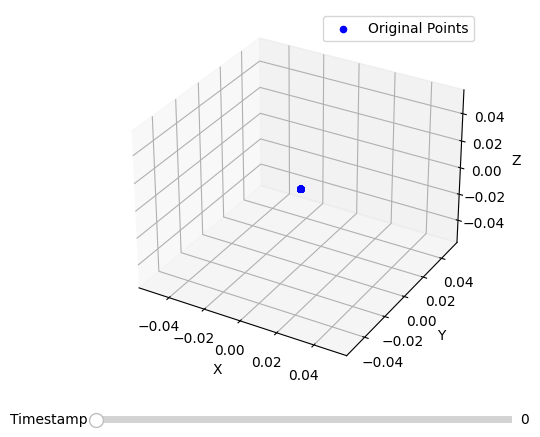

In [11]:
normalized_points = np.array(right_hand_deque)

# Create the figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initial timestamp index
initial_timestamp_index = 0

# Plotting the original points for the initial timestamp
scatter = ax.scatter(normalized_points[initial_timestamp_index, :,0], 
                     normalized_points[initial_timestamp_index, :,1], 
                     normalized_points[initial_timestamp_index, :,2],
                     c='blue', label='Original Points')

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Create a slider axes
ax_slider = plt.axes([0.2, 0.01, 0.65, 0.03], facecolor='lightgoldenrodyellow')

# Create a slider
slider = Slider(ax_slider, 'Timestamp', 0, normalized_points.shape[0] - 1, valinit=initial_timestamp_index, valstep=1)

# Update function for the slider
def update(val):
    timestamp_index = int(slider.val)
    
    # Update the scatter plot with the new points for the selected timestamp
    scatter._offsets3d = (normalized_points[timestamp_index, :,0],
                          normalized_points[timestamp_index, :,1],
                          normalized_points[timestamp_index, :,2])

    # Redraw the plot
    fig.canvas.draw_idle()

# Connect the slider to the update function
slider.on_changed(update)

plt.show()

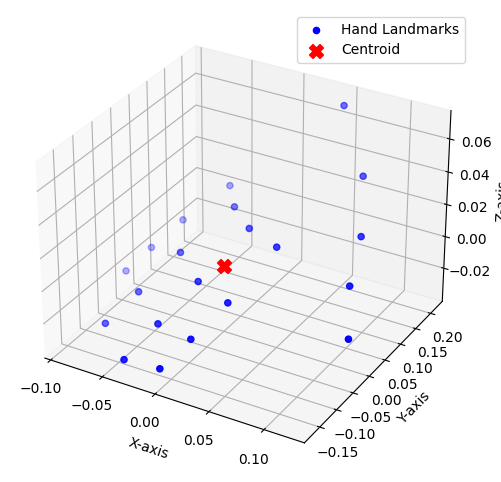

In [28]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
time_point=554
# Plotting the original points
ax.scatter(normalized_points[time_point,:, 0], normalized_points[time_point,:, 1], normalized_points[time_point,:, 2], c='blue', label='Hand Landmarks')

# Plotting the centroid
ax.scatter(0,0,0, c='red', marker='X', s=100, label='Centroid')

# Adding labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

# Display the 3D plot
#plt.show()
output_path = PATH + r'\Media\HHCentroid.svg'
plt.savefig(output_path, format='svg', edgecolor='none')

# Create DB to Store app Data

In [ ]:
# import sqlite3
# conn = sqlite3.connect(PATH + r'\\app\\DataBase\\HandHygiene_database.db')
# cursor = conn.cursor()
# cursor.execute('''
#     CREATE TABLE IF NOT EXISTS my_table (
#         id INTEGER PRIMARY KEY AUTOINCREMENT,
#         date_time DATETIME,
#         Step_1 REAL,
#         Step_2_1 REAL,
#         Step_2_2 REAL,
#         Step_3 REAL,
#         Step_4_1 REAL,
#         Step_4_2 REAL,
#         Step_5_1 REAL,
#         Step_5_2 REAL,
#         Step_6_1 REAL,
#         Step_6_2 REAL,
#         No_Step REAL
#     )
# ''')

# # Confirmar los cambios
# conn.commit()
# conn.close()